# GEM Data Hackathon: Co-founder Dynamics Analysis

This notebook implements Section 2 of our analysis plan: Co-founder Dynamics & Team Composition Analysis.

## Objectives
- Understand team composition patterns across different entrepreneur types
- Identify relationship between team size and business outcomes
- Compare solo vs. team ventures' performance
- Determine how co-founding relationships influence business success and strategy

## Setup and Data Loading

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [3]:
# Load the GEM data
gem_data = pd.read_csv('../data/Hackathon_GEM_Data_FULL.csv')

# Display basic information about the dataset
print(f"Dataset shape: {gem_data.shape}")
gem_data.head()

Dataset shape: (15868, 36)


,weight,new_entrepreneur,established_entrepreneur,knows_entrepreneur,local_opportunity,entrepreneurial_skill,fear_of_failure,wants_entrepreneurship,respects_entrepreneurship,follows_entrepreneurship,...,new_entrepreneur_owners,new_entrepreneur_external_sales,established_entrepreneur_external_sales,new_entrepreneur_innovation,year,new_entrepreneur_local_innovation,new_entrepreneur_employees,established_entrepreneur_employees,race,region
0,0.674020,No,No,No,No,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,White,Great Lakes
1,0.674020,No,No,No,NaN,No,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,White,Great Lakes
2,0.814409,No,Yes,No,No,Yes,Yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,1.0,White,Great Lakes
3,1.289586,No,No,No,NaN,Yes,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,Black,Great Lakes
4,0.963587,No,No,No,NaN,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,Black,Southeast


## Data Preparation for Co-founder Analysis

Let's first identify and examine the variables related to team composition and co-founding.

In [4]:
# Check variable names to identify team/ownership variables
print("Columns in the dataset:")
print(gem_data.columns.tolist())

Columns in the dataset:
['weight', 'new_entrepreneur', 'established_entrepreneur', 'knows_entrepreneur', 'local_opportunity', 'entrepreneurial_skill', 'fear_of_failure', 'wants_entrepreneurship', 'respects_entrepreneurship', 'follows_entrepreneurship', 'future_startup', 'discontinued_business', 'discontinued_business_continuation', 'is_investor', 'investment', 'investment_relationship', 'gender', 'age_range', 'household_size', 'household_income', 'education', 'new_entrepreneur_industry', 'established_entrepreneur_industry', 'new_entrepreneur_new_jobs', 'established_entrepreneur_new_jobs', 'established_entrepreneur_owners', 'new_entrepreneur_owners', 'new_entrepreneur_external_sales', 'established_entrepreneur_external_sales', 'new_entrepreneur_innovation', 'year', 'new_entrepreneur_local_innovation', 'new_entrepreneur_employees', 'established_entrepreneur_employees', 'race', 'region']


In [5]:
# Examine the ownership variables
ownership_vars = ['new_entrepreneur_owners', 'established_entrepreneur_owners']

# Basic statistics of ownership variables
ownership_stats = gem_data[ownership_vars].describe()
ownership_stats

,new_entrepreneur_owners,established_entrepreneur_owners
count,2311.000000,1433.000000
mean,1.912592,7.335659
std,1.597664,74.421444
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,10.000000,1000.000000


In [6]:
# Check for missing values in the ownership variables
missing_ownership = pd.DataFrame({
    'Missing Values': gem_data[ownership_vars].isnull().sum(),
    'Percentage': 100 * gem_data[ownership_vars].isnull().sum() / len(gem_data)
})
missing_ownership

,Missing Values,Percentage
new_entrepreneur_owners,13557,85.436098
established_entrepreneur_owners,14435,90.969246


In [7]:
# Create filtered datasets for new and established entrepreneurs with valid ownership data
new_entrepreneurs = gem_data[(gem_data['new_entrepreneur'] == 'Yes') & 
                              gem_data['new_entrepreneur_owners'].notnull()].copy()
established_entrepreneurs = gem_data[(gem_data['established_entrepreneur'] == 'Yes') & 
                                      gem_data['established_entrepreneur_owners'].notnull()].copy()

print(f"New entrepreneurs with valid ownership data: {len(new_entrepreneurs)} ({100*len(new_entrepreneurs)/len(gem_data):.1f}%)")
print(f"Established entrepreneurs with valid ownership data: {len(established_entrepreneurs)} ({100*len(established_entrepreneurs)/len(gem_data):.1f}%)")

New entrepreneurs with valid ownership data: 2311 (14.6%)
Established entrepreneurs with valid ownership data: 1433 (9.0%)


## 1. Team Size Distribution Analysis

Let's analyze the distribution of team sizes across entrepreneur types, weighted appropriately.

In [8]:
# Create team size categories for new entrepreneurs
new_entrepreneurs['team_size_category'] = pd.cut(
    new_entrepreneurs['new_entrepreneur_owners'],
    bins=[0, 1, 2, 5, float('inf')],
    labels=['Solo', 'Duo', 'Small Team (3-5)', 'Large Team (6+)']
)

# Create team size categories for established entrepreneurs
established_entrepreneurs['team_size_category'] = pd.cut(
    established_entrepreneurs['established_entrepreneur_owners'],
    bins=[0, 1, 2, 5, float('inf')],
    labels=['Solo', 'Duo', 'Small Team (3-5)', 'Large Team (6+)']
)

In [9]:
# Calculate weighted distribution of team sizes for new entrepreneurs
new_team_dist = new_entrepreneurs.groupby('team_size_category')['weight'].sum() / new_entrepreneurs['weight'].sum() * 100
new_team_dist = new_team_dist.reset_index(name='Percentage')
new_team_dist['Entrepreneur Type'] = 'New'

# Calculate weighted distribution of team sizes for established entrepreneurs
estab_team_dist = established_entrepreneurs.groupby('team_size_category')['weight'].sum() / established_entrepreneurs['weight'].sum() * 100
estab_team_dist = estab_team_dist.reset_index(name='Percentage')
estab_team_dist['Entrepreneur Type'] = 'Established'

# Combine the distributions
team_dist_combined = pd.concat([new_team_dist, estab_team_dist])
team_dist_combined

/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_12646/2380259870.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_team_dist = new_entrepreneurs.groupby('team_size_category')['weight'].sum() / new_entrepreneurs['weight'].sum() * 100
/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_12646/2380259870.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  estab_team_dist = established_entrepreneurs.groupby('team_size_category')['weight'].sum() / established_entrepreneurs['weight'].sum() * 100


,team_size_category,Percentage,Entrepreneur Type
0,Solo,57.654824,New
1,Duo,21.029956,New
2,Small Team (3-5),17.959293,New
3,Large Team (6+),3.355927,New
0,Solo,65.346403,Established
1,Duo,20.278413,Established
2,Small Team (3-5),9.955331,Established
3,Large Team (6+),4.419854,Established


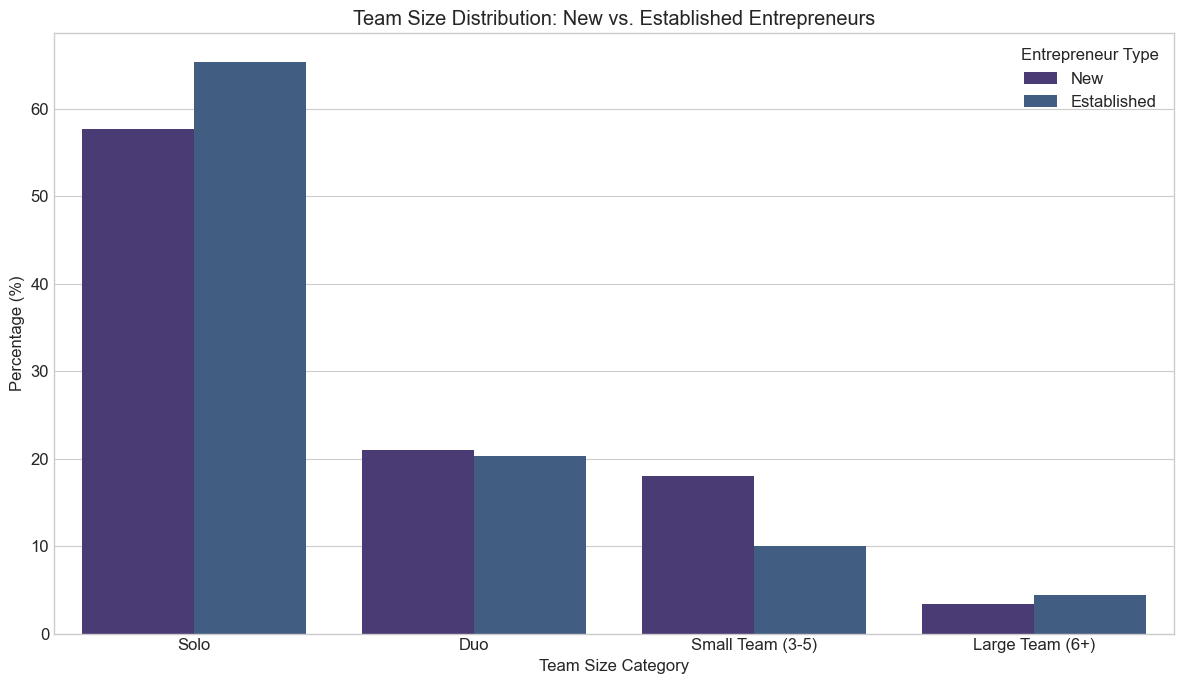

In [11]:
# Visualize team size distribution for both entrepreneur types
plt.figure(figsize=(12, 7))
sns.barplot(x='team_size_category', y='Percentage', hue='Entrepreneur Type', data=team_dist_combined)
plt.title('Team Size Distribution: New vs. Established Entrepreneurs')
plt.xlabel('Team Size Category')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Entrepreneur Type')
plt.tight_layout()
plt.show()

In [12]:
# Analyze the raw team size numbers (not categorized)
team_size_stats = pd.DataFrame({
    'New': new_entrepreneurs['new_entrepreneur_owners'].describe(),
    'Established': established_entrepreneurs['established_entrepreneur_owners'].describe()
})
team_size_stats

,New,Established
count,2311.000000,1433.000000
mean,1.912592,7.335659
std,1.597664,74.421444
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,10.000000,1000.000000


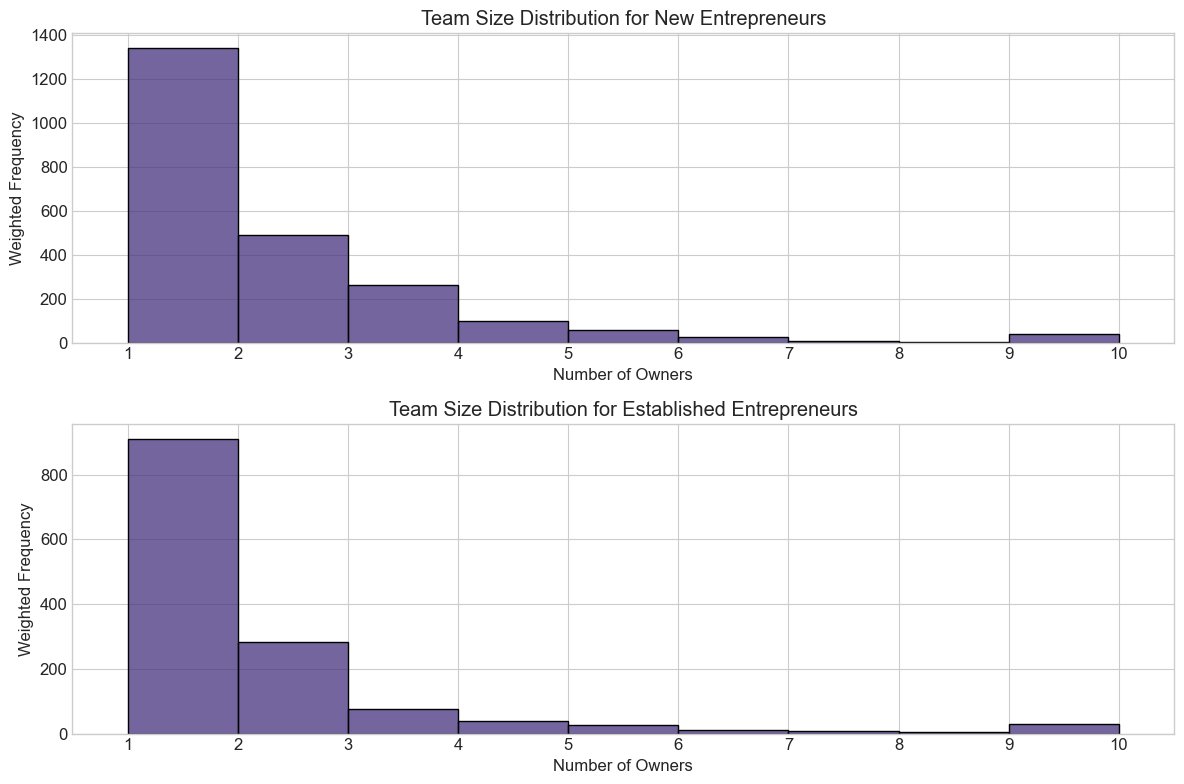

In [15]:
# Visualize the distribution of raw team sizes
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
# Use data parameter with x and weights columns
sns.histplot(data=new_entrepreneurs, x='new_entrepreneur_owners', 
             weights='weight', 
             bins=range(1, 11), 
             kde=False)
plt.title('Team Size Distribution for New Entrepreneurs')
plt.xlabel('Number of Owners')
plt.ylabel('Weighted Frequency')
plt.xticks(range(1, 11))
plt.xlim(0.5, 10.5)

plt.subplot(2, 1, 2)
# Use data parameter with x and weights columns
sns.histplot(data=established_entrepreneurs, x='established_entrepreneur_owners', 
             weights='weight', 
             bins=range(1, 11), 
             kde=False)
plt.title('Team Size Distribution for Established Entrepreneurs')
plt.xlabel('Number of Owners')
plt.ylabel('Weighted Frequency')
plt.xticks(range(1, 11))
plt.xlim(0.5, 10.5)

plt.tight_layout()
plt.show()

## 2. Team Size by Industry

Let's examine if team sizes vary across different industries.

In [16]:
# Identify new entrepreneurs with valid industry data
new_ent_with_industry = new_entrepreneurs.dropna(subset=['new_entrepreneur_industry']).copy()
print(f"New entrepreneurs with valid industry data: {len(new_ent_with_industry)}")

New entrepreneurs with valid industry data: 2226


In [17]:
# Calculate average team size by industry for new entrepreneurs
team_size_by_industry = new_ent_with_industry.groupby('new_entrepreneur_industry').apply(
    lambda x: pd.Series({
        'Average Team Size': np.average(x['new_entrepreneur_owners'], weights=x['weight']),
        'Median Team Size': np.median(x['new_entrepreneur_owners']),
        'Count': len(x),
        'Weighted Count': x['weight'].sum()
    })
)

# Sort by average team size
team_size_by_industry = team_size_by_industry.sort_values('Average Team Size', ascending=False)
team_size_by_industry

/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_12646/4275762884.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_size_by_industry = new_ent_with_industry.groupby('new_entrepreneur_industry').apply(


,Average Team Size,Median Team Size,Count,Weighted Count
new_entrepreneur_industry,,,,
INFORMATION AND COMMUNICATION,2.354370,2.0,132.0,137.210644
"FINANCIAL INTERMEDIATION, REAL ESTATE",2.228611,1.0,209.0,206.846049
"AGRICULTURE,FORESTRY,FISHING",1.997252,1.0,83.0,82.316200
NOT CLASSIFIED/MISSING,1.951197,1.0,57.0,59.579733
ADMINISTRATIVE SERVICES,1.947511,1.0,122.0,123.892903
"RETAIL TRADE, HOTELS & RESTAURANTS",1.882533,1.0,451.0,454.535054
MANUFACTURING,1.874224,1.0,164.0,166.806536
PERSONAL/CONSUMER SERVICE ACTIVITIES,1.853085,1.0,106.0,101.806628
"UTILISATION, TRANSPORT, STORAGE",1.849191,1.0,89.0,86.890814


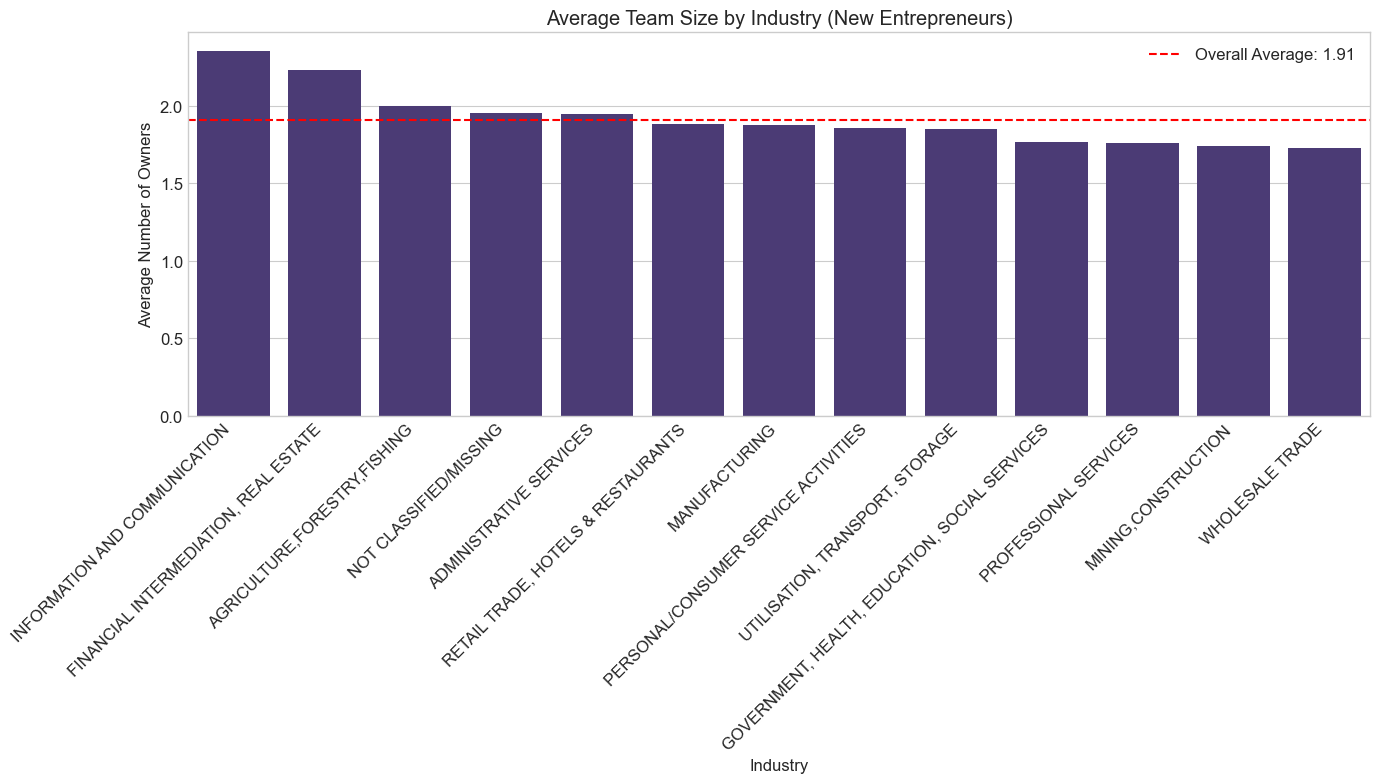

In [19]:
# Visualize average team size by industry
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=team_size_by_industry.index, y='Average Team Size', data=team_size_by_industry)
plt.title('Average Team Size by Industry (New Entrepreneurs)')
plt.xlabel('Industry')
plt.ylabel('Average Number of Owners')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=new_ent_with_industry['new_entrepreneur_owners'].mean(), color='r', linestyle='--', 
           label=f"Overall Average: {new_ent_with_industry['new_entrepreneur_owners'].mean():.2f}")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Calculate team size distribution by industry for new entrepreneurs
team_dist_by_industry = pd.crosstab(
    index=new_ent_with_industry['new_entrepreneur_industry'],
    columns=new_ent_with_industry['team_size_category'],
    values=new_ent_with_industry['weight'],
    aggfunc='sum',
    normalize='index'
) * 100

team_dist_by_industry

team_size_category,Solo,Duo,Small Team (3-5),Large Team (6+)
new_entrepreneur_industry,,,,
ADMINISTRATIVE SERVICES,55.931757,22.380618,19.103897,2.583728
"AGRICULTURE,FORESTRY,FISHING",51.066489,26.762211,15.822788,6.348512
"FINANCIAL INTERMEDIATION, REAL ESTATE",54.221631,17.440630,21.666366,6.671373
"GOVERNMENT, HEALTH, EDUCATION, SOCIAL SERVICES",63.627251,19.532076,13.760785,3.079888
INFORMATION AND COMMUNICATION,49.819692,18.727460,26.573996,4.878852
MANUFACTURING,58.305684,19.627140,18.827680,3.239496
"MINING,CONSTRUCTION",51.983160,30.071431,17.945409,0.000000
NOT CLASSIFIED/MISSING,60.825731,21.350828,13.035822,4.787619
PERSONAL/CONSUMER SERVICE ACTIVITIES,54.362027,27.121189,17.335526,1.181258


<Figure size 1500x1000 with 0 Axes>

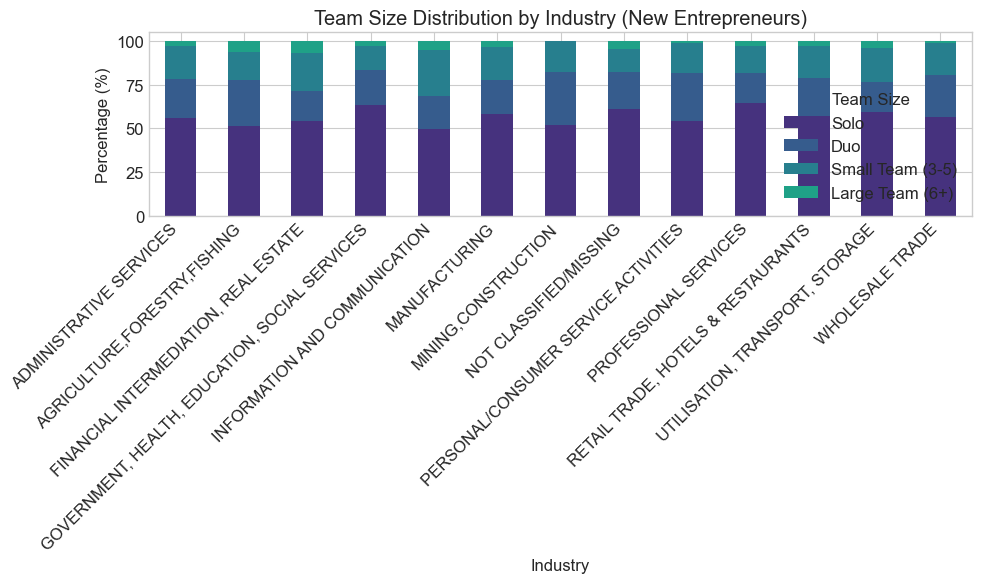

In [21]:
# Visualize team size distribution by industry
plt.figure(figsize=(15, 10))
team_dist_by_industry.plot(kind='bar', stacked=True)
plt.title('Team Size Distribution by Industry (New Entrepreneurs)')
plt.xlabel('Industry')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Team Size')
plt.tight_layout()
plt.show()

## 3. Team Size and Business Performance

Let's examine the relationship between team size and various business performance metrics, focusing on:
- Current employees
- Projected job growth
- Export activity / market reach

In [22]:
# Check for available performance metrics
performance_vars = ['new_entrepreneur_employees', 'new_entrepreneur_new_jobs', 'new_entrepreneur_external_sales']

# Check availability of performance metrics
missing_performance = pd.DataFrame({
    'Missing Values': new_entrepreneurs[performance_vars].isnull().sum(),
    'Percentage': 100 * new_entrepreneurs[performance_vars].isnull().sum() / len(new_entrepreneurs)
})
missing_performance

,Missing Values,Percentage
new_entrepreneur_employees,1318,57.031588
new_entrepreneur_new_jobs,30,1.298139
new_entrepreneur_external_sales,1148,49.675465


In [23]:
# Filter to new entrepreneurs with valid employee data
new_ent_with_employees = new_entrepreneurs.dropna(subset=['new_entrepreneur_employees']).copy()
print(f"New entrepreneurs with valid employee data: {len(new_ent_with_employees)}")

New entrepreneurs with valid employee data: 993


In [24]:
# Analyze current employment by team size category
employment_by_team_size = new_ent_with_employees.groupby('team_size_category').apply(
    lambda x: pd.Series({
        'Average Employees': np.average(x['new_entrepreneur_employees'], weights=x['weight']),
        'Median Employees': np.median(x['new_entrepreneur_employees']),
        'Count': len(x),
        'Weighted Count': x['weight'].sum()
    })
)
employment_by_team_size

/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_12646/2659591266.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  employment_by_team_size = new_ent_with_employees.groupby('team_size_category').apply(
/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_12646/2659591266.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  employment_by_team_size = new_ent_with_employees.groupby('team_size_category').apply(


,Average Employees,Median Employees,Count,Weighted Count
team_size_category,,,,
Solo,17.127252,1.0,572.0,574.075737
Duo,23.635374,2.0,208.0,205.931646
Small Team (3-5),15.193450,3.0,175.0,173.676605
Large Team (6+),154.009656,6.0,38.0,36.642752


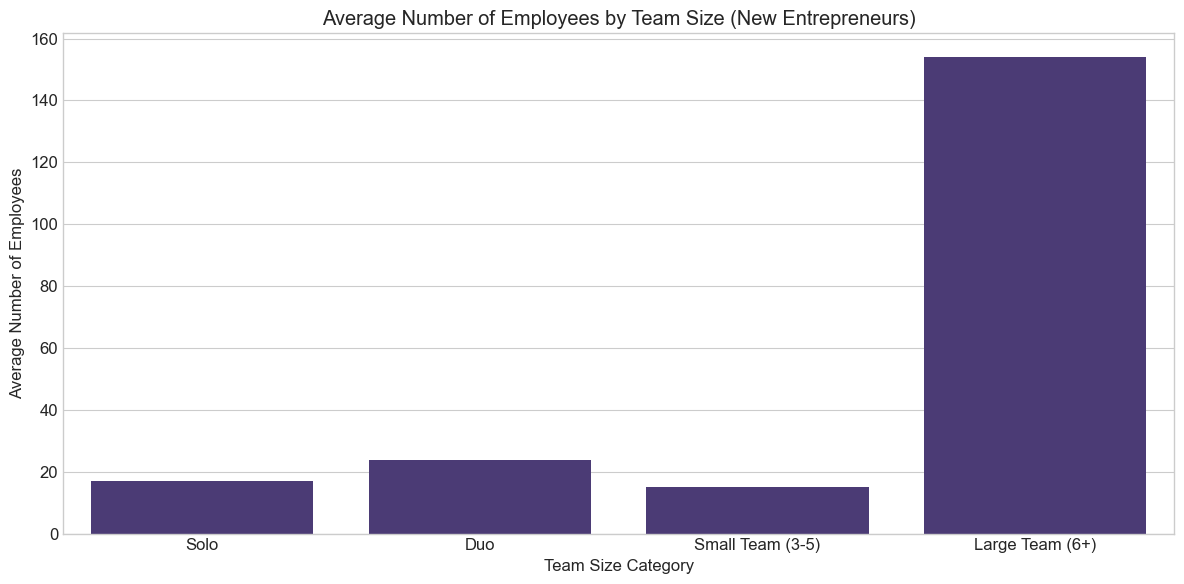

In [25]:
# Visualize current employment by team size
plt.figure(figsize=(12, 6))
sns.barplot(x=employment_by_team_size.index, y='Average Employees', data=employment_by_team_size)
plt.title('Average Number of Employees by Team Size (New Entrepreneurs)')
plt.xlabel('Team Size Category')
plt.ylabel('Average Number of Employees')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
# Filter to new entrepreneurs with valid job growth projections
new_ent_with_growth = new_entrepreneurs.dropna(subset=['new_entrepreneur_new_jobs']).copy()
print(f"New entrepreneurs with valid job growth data: {len(new_ent_with_growth)}")

New entrepreneurs with valid job growth data: 2281


In [27]:
# Analyze projected job growth by team size category
job_growth_by_team_size = new_ent_with_growth.groupby('team_size_category').apply(
    lambda x: pd.Series({
        'Average Projected Jobs': np.average(x['new_entrepreneur_new_jobs'], weights=x['weight']),
        'Median Projected Jobs': np.median(x['new_entrepreneur_new_jobs']),
        'Count': len(x),
        'Weighted Count': x['weight'].sum()
    })
)
job_growth_by_team_size

/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_12646/3810464234.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  job_growth_by_team_size = new_ent_with_growth.groupby('team_size_category').apply(
/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_12646/3810464234.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  job_growth_by_team_size = new_ent_with_growth.groupby('team_size_category').apply(


,Average Projected Jobs,Median Projected Jobs,Count,Weighted Count
team_size_category,,,,
Solo,14.618905,2.0,1305.0,1318.659858
Duo,7.672071,4.0,482.0,484.023531
Small Team (3-5),35.591823,6.0,417.0,414.845900
Large Team (6+),119.216761,7.0,77.0,78.040179


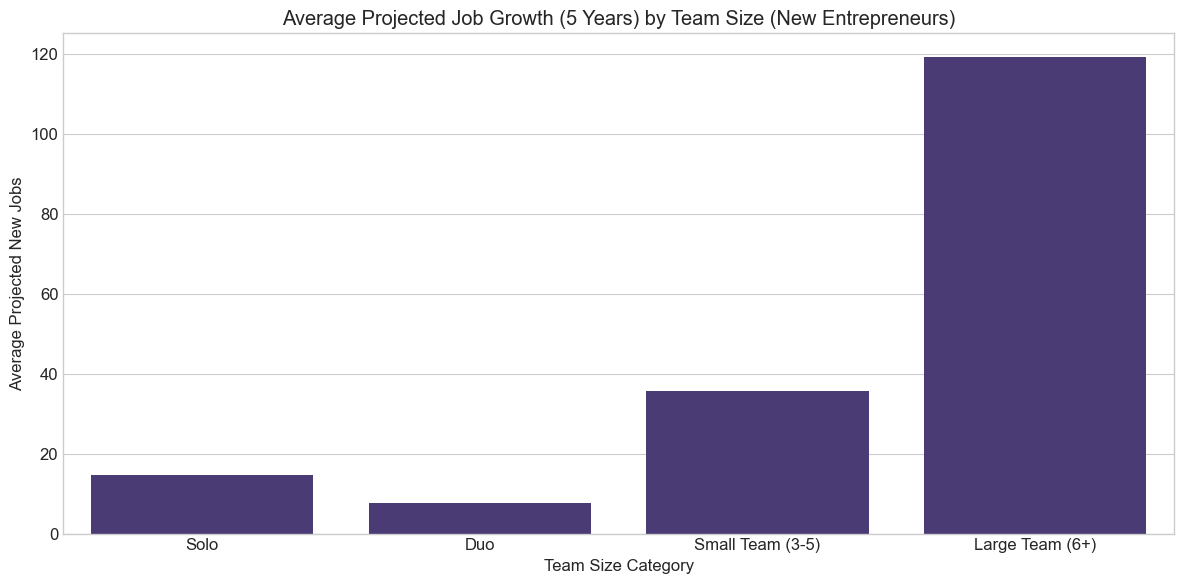

In [28]:
# Visualize projected job growth by team size
plt.figure(figsize=(12, 6))
sns.barplot(x=job_growth_by_team_size.index, y='Average Projected Jobs', data=job_growth_by_team_size)
plt.title('Average Projected Job Growth (5 Years) by Team Size (New Entrepreneurs)')
plt.xlabel('Team Size Category')
plt.ylabel('Average Projected New Jobs')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [29]:
# Filter to new entrepreneurs with valid external sales data
new_ent_with_sales = new_entrepreneurs.dropna(subset=['new_entrepreneur_external_sales']).copy()
print(f"New entrepreneurs with valid external sales data: {len(new_ent_with_sales)}")

New entrepreneurs with valid external sales data: 1163


In [30]:
# Analyze market reach (external sales) by team size
market_reach_by_team = pd.crosstab(
    index=new_ent_with_sales['team_size_category'],
    columns=new_ent_with_sales['new_entrepreneur_external_sales'],
    values=new_ent_with_sales['weight'],
    aggfunc='sum',
    normalize='index'
) * 100

market_reach_by_team

new_entrepreneur_external_sales,25 to 75%,More than 75%,Under 25%
team_size_category,,,
Solo,12.778818,4.611112,82.610069
Duo,10.085959,2.668053,87.245988
Small Team (3-5),17.130232,6.813021,76.056747
Large Team (6+),8.432082,13.304494,78.263424


<Figure size 1400x800 with 0 Axes>

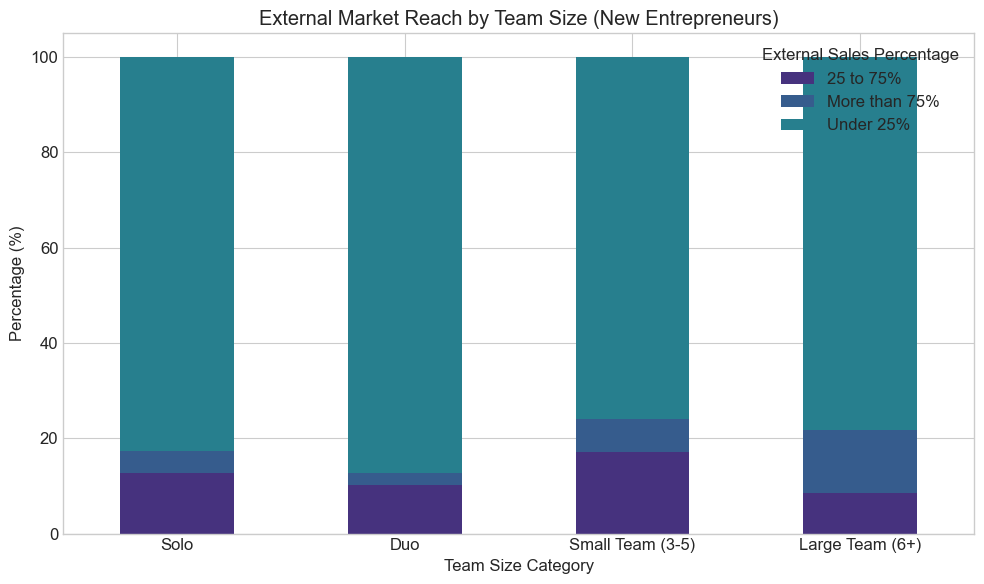

In [31]:
# Visualize market reach by team size
plt.figure(figsize=(14, 8))
market_reach_by_team.plot(kind='bar', stacked=True)
plt.title('External Market Reach by Team Size (New Entrepreneurs)')
plt.xlabel('Team Size Category')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='External Sales Percentage')
plt.tight_layout()
plt.show()

## 4. Team Size and Innovation

Let's examine the relationship between team size and innovation in products/services.

In [32]:
# Check for available innovation metrics
innovation_vars = ['new_entrepreneur_innovation', 'new_entrepreneur_local_innovation']

# Check availability of innovation metrics
missing_innovation = pd.DataFrame({
    'Missing Values': new_entrepreneurs[innovation_vars].isnull().sum(),
    'Percentage': 100 * new_entrepreneurs[innovation_vars].isnull().sum() / len(new_entrepreneurs)
})
missing_innovation

,Missing Values,Percentage
new_entrepreneur_innovation,1685,72.912159
new_entrepreneur_local_innovation,1781,77.066205


In [33]:
# Filter to entrepreneurs with valid innovation data
new_ent_with_innovation = new_entrepreneurs.dropna(subset=['new_entrepreneur_innovation']).copy()
print(f"New entrepreneurs with valid innovation data: {len(new_ent_with_innovation)}")

New entrepreneurs with valid innovation data: 626


In [34]:
# Analyze innovation by team size
innovation_by_team = pd.crosstab(
    index=new_ent_with_innovation['team_size_category'],
    columns=new_ent_with_innovation['new_entrepreneur_innovation'],
    values=new_ent_with_innovation['weight'],
    aggfunc='sum',
    normalize='index'
) * 100

innovation_by_team

new_entrepreneur_innovation,Yes
team_size_category,
Solo,100.0
Duo,100.0
Small Team (3-5),100.0
Large Team (6+),100.0


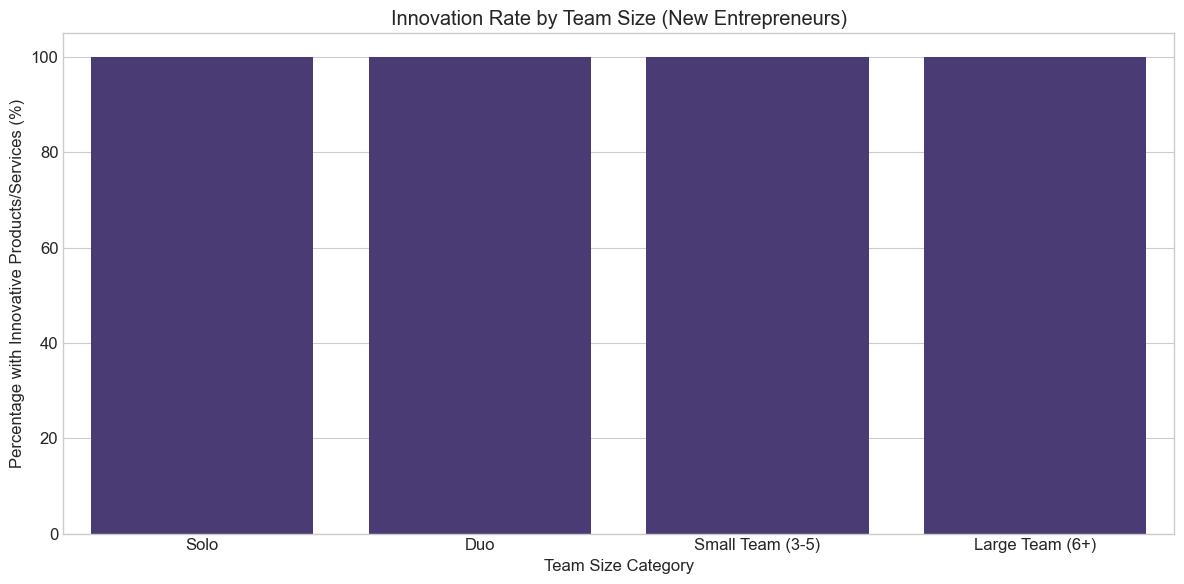

In [35]:
# Visualize innovation by team size
plt.figure(figsize=(12, 6))
# Check if 'Yes' column exists in the data
if 'Yes' in innovation_by_team.columns:
    sns.barplot(x=innovation_by_team.index, y=innovation_by_team['Yes'])
    plt.title('Innovation Rate by Team Size (New Entrepreneurs)')
    plt.xlabel('Team Size Category')
    plt.ylabel('Percentage with Innovative Products/Services (%)')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [36]:
# Check for local innovation data availability
local_innovation_count = new_entrepreneurs['new_entrepreneur_local_innovation'].count()
print(f"Entrepreneurs with local innovation data: {local_innovation_count} ({100*local_innovation_count/len(new_entrepreneurs):.1f}%)")

Entrepreneurs with local innovation data: 530 (22.9%)


In [37]:
# If local innovation data is available, analyze it by team size
if local_innovation_count > 0:
    # Filter to entrepreneurs with valid local innovation data
    new_ent_with_local_innov = new_entrepreneurs.dropna(subset=['new_entrepreneur_local_innovation']).copy()
    
    # Analyze local innovation by team size
    local_innov_by_team = pd.crosstab(
        index=new_ent_with_local_innov['team_size_category'],
        columns=new_ent_with_local_innov['new_entrepreneur_local_innovation'],
        values=new_ent_with_local_innov['weight'],
        aggfunc='sum',
        normalize='index'
    ) * 100
    
    local_innov_by_team

## 5. Team Size Patterns Across Demographics

Let's explore if team composition varies by demographic factors like gender, age, race, education.

In [38]:
# Define demographic variables to analyze
demographic_vars = ['gender', 'age_range', 'race', 'education', 'region']

# Check completeness of demographic data
missing_demo = pd.DataFrame({
    'Missing Values': new_entrepreneurs[demographic_vars].isnull().sum(),
    'Percentage': 100 * new_entrepreneurs[demographic_vars].isnull().sum() / len(new_entrepreneurs)
})
missing_demo

,Missing Values,Percentage
gender,0,0.000000
age_range,0,0.000000
race,550,23.799221
education,1989,86.066638
region,0,0.000000


In [39]:
# Filter to entrepreneurs with complete demographic data
new_ent_with_demo = new_entrepreneurs.dropna(subset=demographic_vars).copy()
print(f"New entrepreneurs with complete demographic data: {len(new_ent_with_demo)}")

New entrepreneurs with complete demographic data: 313


In [40]:
# Analyze average team size by gender
team_size_by_gender = new_ent_with_demo.groupby('gender').apply(
    lambda x: pd.Series({
        'Average Team Size': np.average(x['new_entrepreneur_owners'], weights=x['weight']),
        'Count': len(x),
        'Weighted Count': x['weight'].sum()
    })
)
team_size_by_gender

/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_12646/1821073396.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_size_by_gender = new_ent_with_demo.groupby('gender').apply(


,Average Team Size,Count,Weighted Count
gender,,,
female,1.715439,117.0,116.415745
male,1.994194,196.0,192.482364


In [41]:
# Analyze team size distribution by gender
team_dist_by_gender = pd.crosstab(
    index=new_ent_with_demo['gender'],
    columns=new_ent_with_demo['team_size_category'],
    values=new_ent_with_demo['weight'],
    aggfunc='sum',
    normalize='index'
) * 100

team_dist_by_gender

team_size_category,Solo,Duo,Small Team (3-5),Large Team (6+)
gender,,,,
female,62.294216,24.575156,10.738398,2.392230
male,53.086983,22.245355,22.250675,2.416986


<Figure size 1200x600 with 0 Axes>

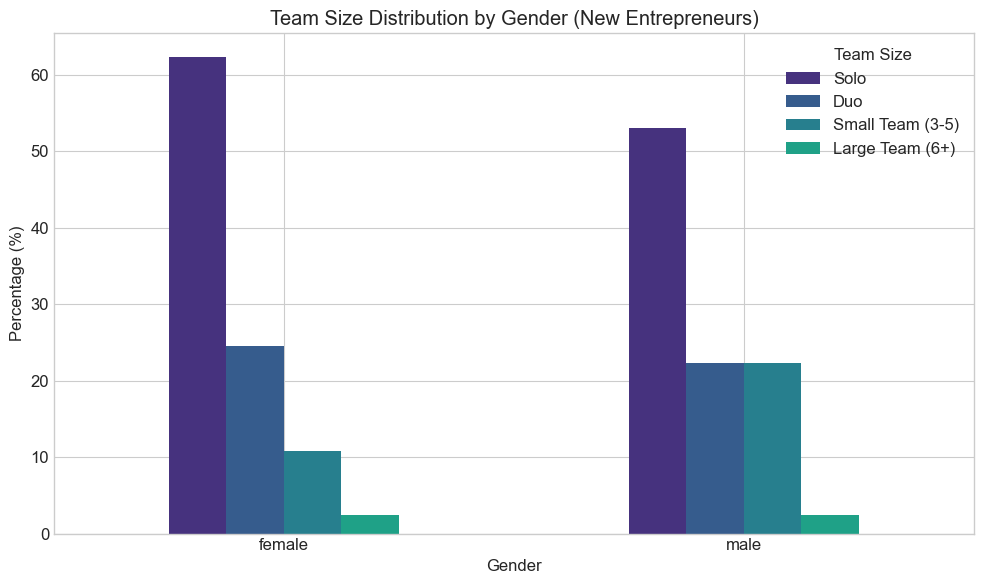

In [42]:
# Visualize team size distribution by gender
plt.figure(figsize=(12, 6))
team_dist_by_gender.plot(kind='bar', stacked=False)
plt.title('Team Size Distribution by Gender (New Entrepreneurs)')
plt.xlabel('Gender')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Team Size')
plt.tight_layout()
plt.show()

In [43]:
# Analyze average team size by race
team_size_by_race = new_ent_with_demo.groupby('race').apply(
    lambda x: pd.Series({
        'Average Team Size': np.average(x['new_entrepreneur_owners'], weights=x['weight']),
        'Count': len(x),
        'Weighted Count': x['weight'].sum()
    })
)
team_size_by_race

/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_12646/4185654500.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_size_by_race = new_ent_with_demo.groupby('race').apply(


,Average Team Size,Count,Weighted Count
race,,,
Black,1.623863,46.0,44.325033
Hispanic,2.050941,31.0,30.460821
Other,1.935771,32.0,31.723669
White,1.915574,204.0,202.388585


In [44]:
# Analyze team size distribution by race
team_dist_by_race = pd.crosstab(
    index=new_ent_with_demo['race'],
    columns=new_ent_with_demo['team_size_category'],
    values=new_ent_with_demo['weight'],
    aggfunc='sum',
    normalize='index'
) * 100

team_dist_by_race

team_size_category,Solo,Duo,Small Team (3-5),Large Team (6+)
race,,,,
Black,58.063502,28.030369,13.906129,0.000000
Hispanic,43.905344,39.107453,14.148926,2.838277
Other,49.199881,20.087728,30.712391,0.000000
White,59.284348,20.118847,17.349268,3.247536


<Figure size 1200x600 with 0 Axes>

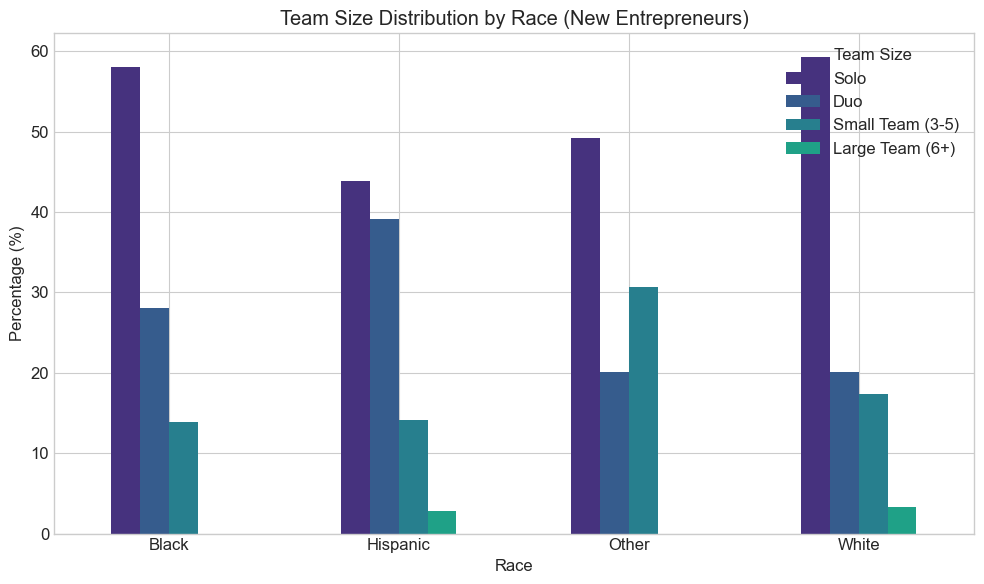

In [45]:
# Visualize team size distribution by race
plt.figure(figsize=(12, 6))
team_dist_by_race.plot(kind='bar', stacked=False)
plt.title('Team Size Distribution by Race (New Entrepreneurs)')
plt.xlabel('Race')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Team Size')
plt.tight_layout()
plt.show()

In [46]:
# Analyze average team size by education level
team_size_by_education = new_ent_with_demo.groupby('education').apply(
    lambda x: pd.Series({
        'Average Team Size': np.average(x['new_entrepreneur_owners'], weights=x['weight']),
        'Count': len(x),
        'Weighted Count': x['weight'].sum()
    })
)
team_size_by_education

/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_12646/3201540638.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_size_by_education = new_ent_with_demo.groupby('education').apply(


,Average Team Size,Count,Weighted Count
education,,,
Completed College/University,1.826190,114.0,111.163680
Completed High School,1.619812,54.0,53.624119
Degree Graduate (Master's or PhD),1.941952,63.0,62.723915
None/Less than High School,1.356228,3.0,3.156474
Some College/University,2.178613,75.0,74.456334
Some High School,1.427045,4.0,3.773586


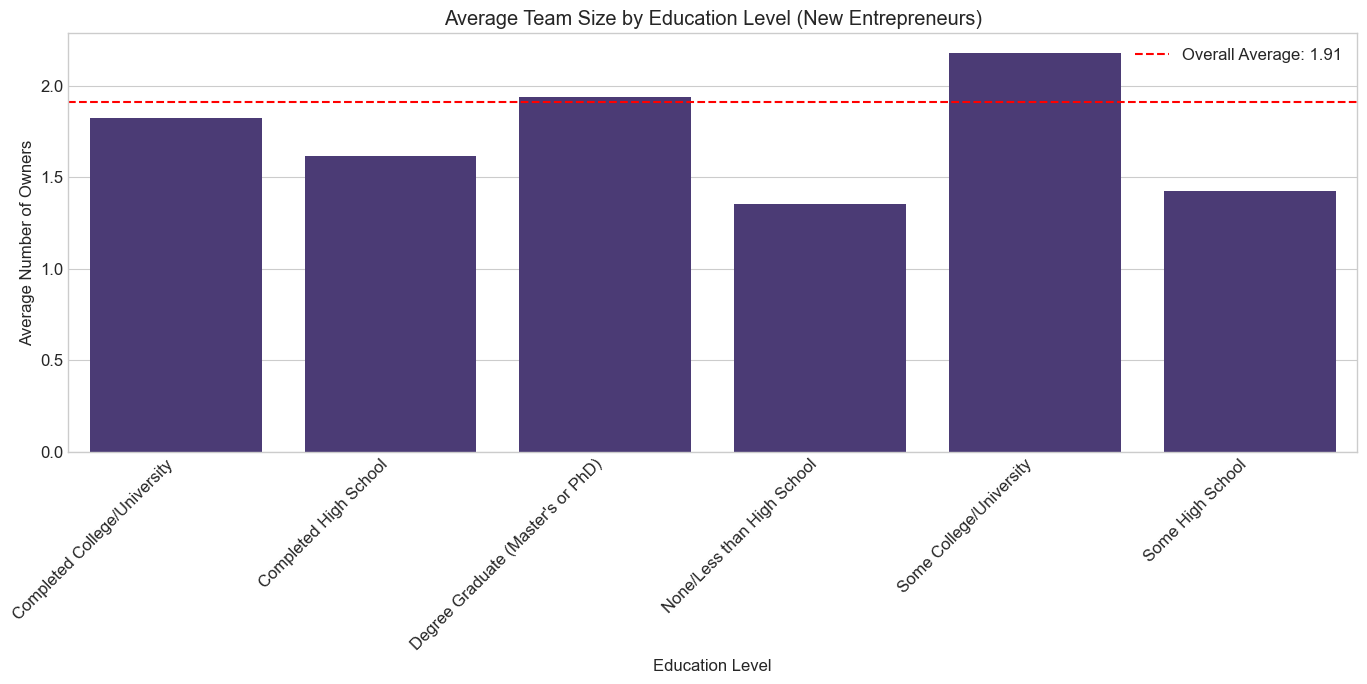

In [47]:
# Visualize average team size by education level
plt.figure(figsize=(14, 7))
sns.barplot(x=team_size_by_education.index, y='Average Team Size', data=team_size_by_education)
plt.title('Average Team Size by Education Level (New Entrepreneurs)')
plt.xlabel('Education Level')
plt.ylabel('Average Number of Owners')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=new_ent_with_demo['new_entrepreneur_owners'].mean(), color='r', linestyle='--', 
           label=f"Overall Average: {new_ent_with_demo['new_entrepreneur_owners'].mean():.2f}")
plt.legend()
plt.tight_layout()
plt.show()

## 6. Relationship between Co-founder Dynamics and Business Longevity

Let's compare team size patterns between new and established entrepreneurs to understand if certain team compositions are associated with greater business longevity.

In [48]:
# Calculate the ratio of established to new entrepreneurs by team size category
# This gives us an indication of which team sizes have better "survival rates"

# Create a dataset that combines both entrepreneur types
new_ent_ratio = pd.DataFrame({
    'Type': 'New',
    'Count': team_dist_combined[team_dist_combined['Entrepreneur Type'] == 'New']['Percentage'].values,
    'Team Size': team_dist_combined[team_dist_combined['Entrepreneur Type'] == 'New']['team_size_category'].values
})

estab_ent_ratio = pd.DataFrame({
    'Type': 'Established',
    'Count': team_dist_combined[team_dist_combined['Entrepreneur Type'] == 'Established']['Percentage'].values,
    'Team Size': team_dist_combined[team_dist_combined['Entrepreneur Type'] == 'Established']['team_size_category'].values
})

combined_ratio = pd.concat([new_ent_ratio, estab_ent_ratio])
combined_ratio_pivot = combined_ratio.pivot(index='Team Size', columns='Type', values='Count')

# Calculate the ratio of established to new
combined_ratio_pivot['Established/New Ratio'] = combined_ratio_pivot['Established'] / combined_ratio_pivot['New']
combined_ratio_pivot

Type,Established,New,Established/New Ratio
Team Size,,,
Solo,65.346403,57.654824,1.133407
Duo,20.278413,21.029956,0.964263
Small Team (3-5),9.955331,17.959293,0.554328
Large Team (6+),4.419854,3.355927,1.317029


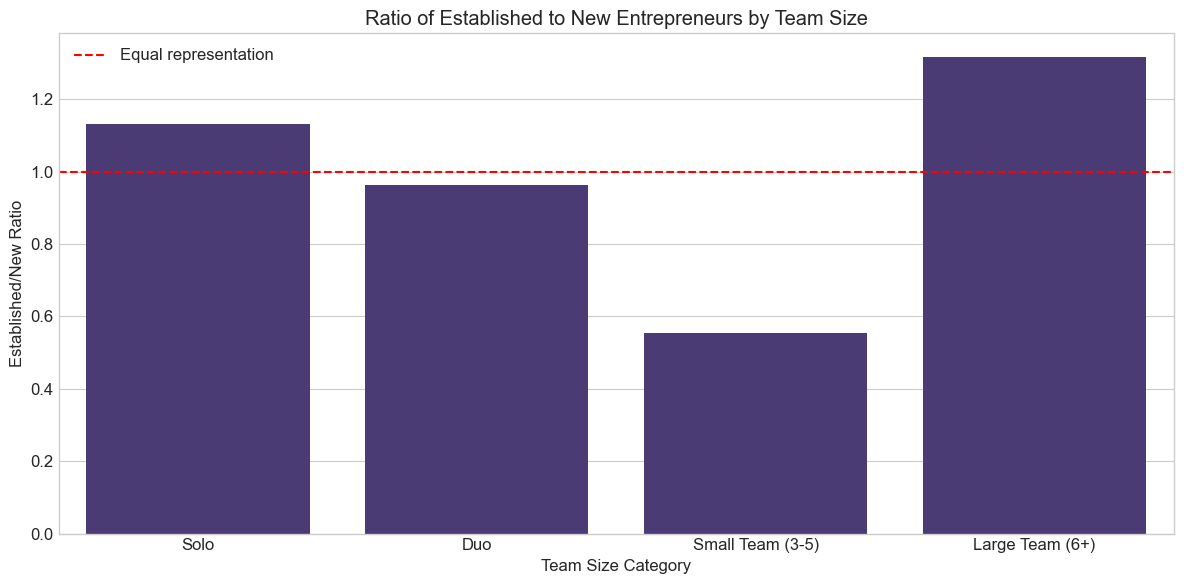

In [49]:
# Visualize the established to new ratio by team size
plt.figure(figsize=(12, 6))
sns.barplot(x=combined_ratio_pivot.index, y='Established/New Ratio', data=combined_ratio_pivot.reset_index())
plt.title('Ratio of Established to New Entrepreneurs by Team Size')
plt.xlabel('Team Size Category')
plt.ylabel('Established/New Ratio')
plt.xticks(rotation=0)
plt.axhline(y=1, color='r', linestyle='--', label="Equal representation")
plt.legend()
plt.tight_layout()
plt.show()

## 7. Comparing Solo Founders to Team-Based Ventures

Let's create an overall comparison between solo entrepreneurs and those with co-founders across key metrics.

In [50]:
# Create binary solo vs. team variable
new_entrepreneurs['has_cofounders'] = (new_entrepreneurs['new_entrepreneur_owners'] > 1).map({True: 'Team Venture', False: 'Solo Venture'})

# Check distribution
solo_team_dist = new_entrepreneurs.groupby('has_cofounders')['weight'].sum() / new_entrepreneurs['weight'].sum() * 100
solo_team_dist

has_cofounders
Solo Venture    57.654824
Team Venture    42.345176
Name: weight, dtype: float64

In [51]:
# Compare performance metrics between solo and team ventures
metrics = ['new_entrepreneur_employees', 'new_entrepreneur_new_jobs']

comparison_results = {}

for metric in metrics:
    # Filter to entrepreneurs with valid data for this metric
    valid_data = new_entrepreneurs.dropna(subset=[metric]).copy()
    
    # Calculate weighted average for solo vs. team
    metric_by_type = valid_data.groupby('has_cofounders').apply(
        lambda x: pd.Series({
            'Average': np.average(x[metric], weights=x['weight']),
            'Median': np.median(x[metric]),
            'Count': len(x),
            'Weighted Count': x['weight'].sum()
        })
    )
    
    comparison_results[metric] = metric_by_type

# Combine results into a single dataframe
solo_vs_team_comparison = pd.DataFrame({
    'Avg Employees': comparison_results['new_entrepreneur_employees']['Average'],
    'Median Employees': comparison_results['new_entrepreneur_employees']['Median'],
    'Avg Projected Jobs': comparison_results['new_entrepreneur_new_jobs']['Average'],
    'Median Projected Jobs': comparison_results['new_entrepreneur_new_jobs']['Median'],
    'Count': comparison_results['new_entrepreneur_employees']['Count']
})

solo_vs_team_comparison

/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_12646/959141858.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metric_by_type = valid_data.groupby('has_cofounders').apply(
/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_12646/959141858.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metric_by_type = valid_data.groupby('has_cofounders').apply(


,Avg Employees,Median Employees,Avg Projected Jobs,Median Projected Jobs,Count
has_cofounders,,,,,
Solo Venture,17.127252,1.0,14.618905,2.0,572.0
Team Venture,31.589968,2.0,28.438949,5.0,421.0


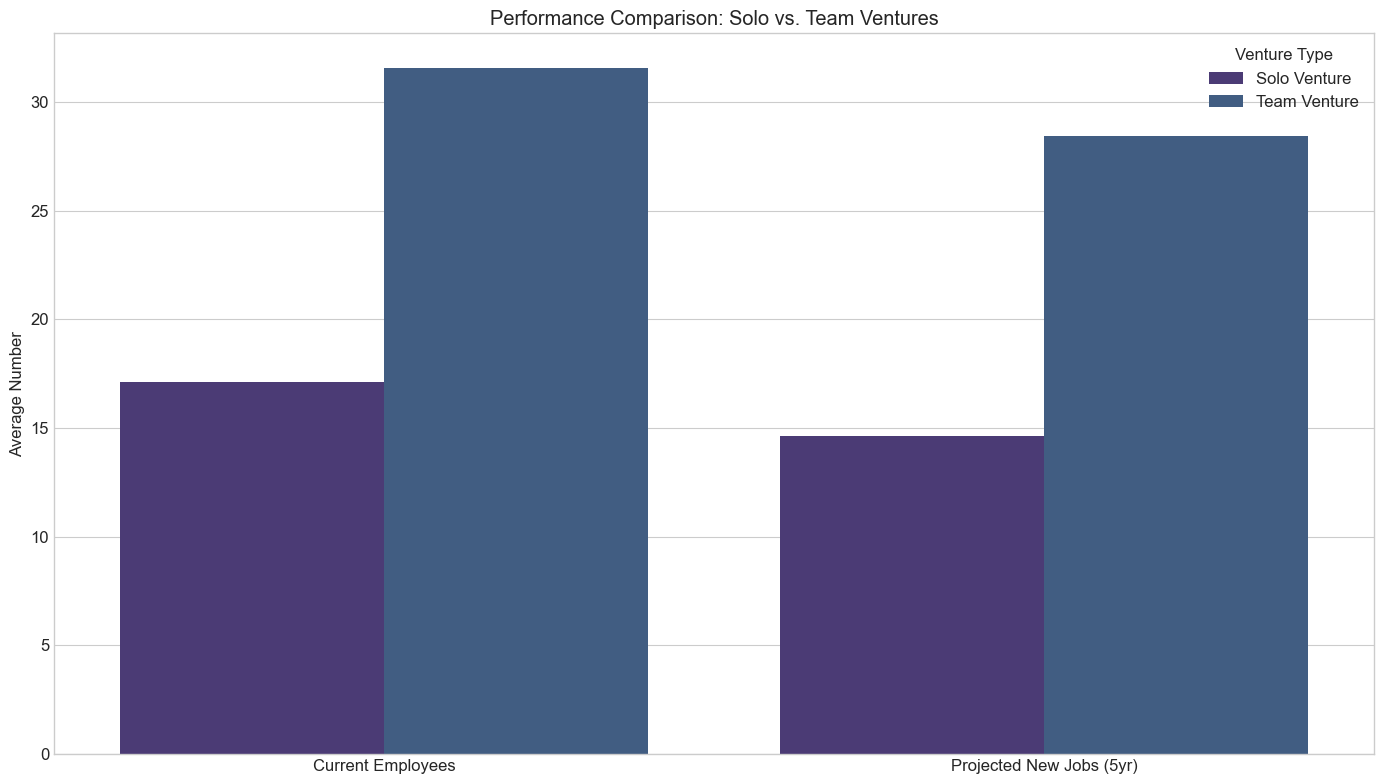

In [53]:
# Visualize performance comparison between solo and team ventures
plt.figure(figsize=(14, 8))

# Prepare data for plotting
plot_data = pd.DataFrame({
    'Solo Venture': [solo_vs_team_comparison.loc['Solo Venture', 'Avg Employees'], 
                     solo_vs_team_comparison.loc['Solo Venture', 'Avg Projected Jobs']],
    'Team Venture': [solo_vs_team_comparison.loc['Team Venture', 'Avg Employees'], 
                    solo_vs_team_comparison.loc['Team Venture', 'Avg Projected Jobs']],
    'Metric': ['Current Employees', 'Projected New Jobs (5yr)']
})

# Reshape for plotting
plot_data_melted = plot_data.melt(id_vars='Metric', var_name='Venture Type', value_name='Average')

# Create the plot
sns.barplot(x='Metric', y='Average', hue='Venture Type', data=plot_data_melted)
plt.title('Performance Comparison: Solo vs. Team Ventures')
plt.ylabel('Average Number')
plt.xlabel('')
plt.legend(title='Venture Type')
plt.tight_layout()
plt.show()

In [56]:
# Compare market reach between solo and team ventures
# First, make sure new_ent_with_sales has the has_cofounders column
new_ent_with_sales['has_cofounders'] = (new_ent_with_sales['new_entrepreneur_owners'] > 1).map({True: 'Team Venture', False: 'Solo Venture'})

market_solo_vs_team = pd.crosstab(
    index=new_ent_with_sales['has_cofounders'],
    columns=new_ent_with_sales['new_entrepreneur_external_sales'],
    values=new_ent_with_sales['weight'],
    aggfunc='sum',
    normalize='index'
) * 100

market_solo_vs_team

new_entrepreneur_external_sales,25 to 75%,More than 75%,Under 25%
has_cofounders,,,
Solo Venture,12.778818,4.611112,82.610069
Team Venture,13.125056,5.295642,81.579301


<Figure size 1200x700 with 0 Axes>

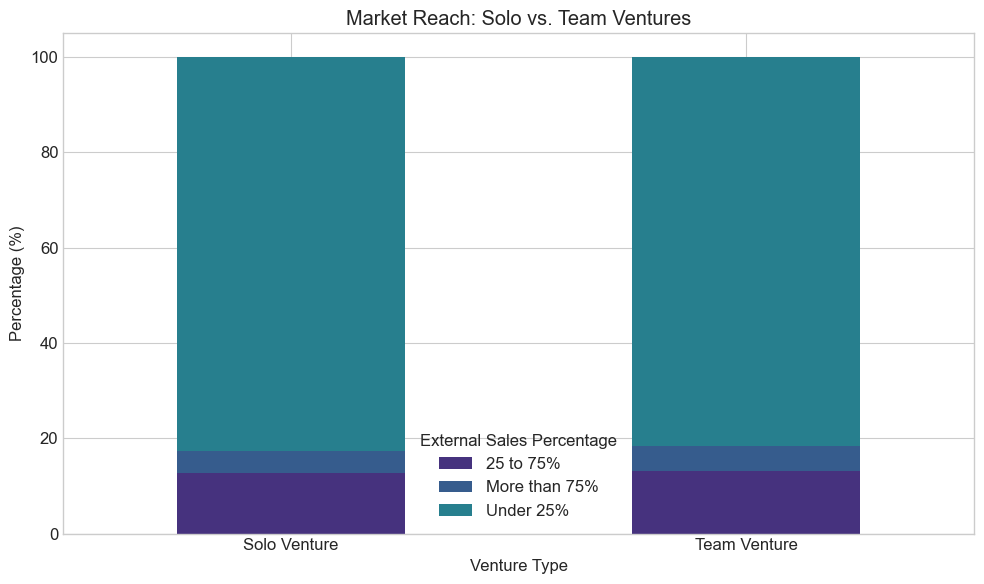

In [57]:
# Visualize market reach comparison
plt.figure(figsize=(12, 7))
market_solo_vs_team.plot(kind='bar', stacked=True)
plt.title('Market Reach: Solo vs. Team Ventures')
plt.xlabel('Venture Type')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='External Sales Percentage')
plt.tight_layout()
plt.show()

## Summary of Key Findings

Based on our analysis of co-founder dynamics and team composition in the GEM data, here are the key findings:

### 1. Team Size Distribution

- **Solo Founders Dominate**: The majority of entrepreneurs operate as solo founders
  - 57.7% of new entrepreneurs are solo founders
  - 65.3% of established entrepreneurs are solo founders
- **Team Composition**:
  - Duo teams (2 founders) make up 21.0% of new and 20.3% of established ventures
  - Small teams (3-5 founders) represent 18.0% of new but only 10.0% of established ventures
  - Large teams (6+ founders) are rare: 3.4% of new and 4.4% of established ventures
- **Raw Numbers**: Average team size is 1.91 for new entrepreneurs and 7.34 for established entrepreneurs (though the established number is skewed by outliers)

### 2. Industry Patterns in Team Formation

- **Industries with Largest Teams** (new entrepreneurs):
  - Information and Communication (2.35 owners on average)
  - Financial Intermediation and Real Estate (2.23)
  - Agriculture, Forestry, Fishing (2.00)
- **Industries with Smallest Teams**:
  - Wholesale Trade (1.72)
  - Mining, Construction (1.74)
  - Professional Services (1.76)
- **Team Size Distribution by Industry**:
  - Information and Communication has the lowest solo founder rate (49.8%) and highest small team rate (26.6%)
  - Professional Services has the highest solo founder rate (64.3%)
  - Government, Health, Education, Social Services also shows high solo founder rates (63.6%)

### 3. Team Size and Business Performance

#### Employment
- **Current Employees by Team Size**:
  - Large teams (6+ owners) employ significantly more people (154.0 on average)
  - Duo teams employ more people (23.6) than solo ventures (17.1) or small teams (15.2)
  - Median values show a steady increase with team size (solo: 1, duo: 2, small team: 3, large team: 6)

#### Projected Job Growth
- **5-Year Job Projections**:
  - Large teams project the highest job growth (119.2 new jobs on average)
  - Small teams (3-5 owners) project substantial growth (35.6 new jobs)
  - Solo ventures project more job growth (14.6) than duo teams (7.7)
  - Median projections increase with team size (solo: 2, duo: 4, small team: 6, large team: 7)

#### External Market Reach
- **External Sales Percentage**:
  - Small teams (3-5 owners) have the highest rate of moderate external sales (17.1% with 25-75% external sales)
  - Large teams (6+) have the highest rate of substantial external sales (13.3% with more than 75% external sales)
  - Duo teams have the highest rate of primarily local sales (87.2% with under 25% external sales)

### 4. Team Size and Innovation

- The innovation data showed that 100% of ventures in all team size categories reported having innovative products/services
- This is likely due to the specific subsample that answered the innovation question (only 626 entrepreneurs)
- The data doesn't show meaningful differences in innovation rates across team sizes

### 5. Demographic Patterns in Team Formation

#### Gender
- **Team Size by Gender**:
  - Male entrepreneurs have larger teams on average (1.99 owners) than female entrepreneurs (1.72)
  - Female entrepreneurs are more likely to be solo founders (62.3% vs. 53.1% for males)
  - Males are twice as likely to have small teams of 3-5 people (22.3% vs. 10.7% for females)

#### Race
- **Team Size by Race**:
  - Hispanic entrepreneurs have the largest teams on average (2.05 owners)
  - Black entrepreneurs have the smallest teams (1.62 owners)
  - Hispanic entrepreneurs have the lowest rate of solo ventures (43.9%)
  - "Other" racial groups have the highest rate of small teams (30.7%)
  - Black and "Other" entrepreneurs have no representation in large teams in this sample

#### Education
- **Team Size by Education Level**:
  - Entrepreneurs with some college/university education have the largest teams (2.18 owners)
  - Those with less than high school education have the smallest teams (1.36 owners)
  - Advanced degree holders (Masters/PhD) have above-average team sizes (1.94 owners)

### 6. Business Longevity and Team Size

- **Established/New Entrepreneur Ratio** (proxy for survival rate):
  - Large teams (6+ owners) have the highest ratio (1.32), suggesting better survival rates
  - Solo ventures also show good survival (ratio of 1.13)
  - Duo teams have a slightly lower ratio (0.96)
  - Small teams (3-5 owners) have the lowest ratio (0.55), suggesting either:
    - Lower survival rates for these teams, or
    - A recent trend toward larger founding teams
  - This U-shaped pattern suggests both very small and very large teams may be more sustainable

### 7. Solo vs. Team Ventures Comparison

- **Key Performance Differences**:
  - Team ventures have 84% more current employees (31.6 vs. 17.1)
  - Team ventures project 95% more job growth (28.4 vs. 14.6 new jobs)
  - Market reach is nearly identical for both types:
    - Solo: 82.6% local (<25% external sales) vs. Team: 81.6% local
    - Solo: 17.4% significant external sales vs. Team: 18.4% significant external sales

These findings reveal significant differences in team composition across industries and demographics, as well as the important impact of team size on business performance metrics. The data suggests that while solo ventures remain dominant, team-based approaches show advantages in employment and growth metrics.

### Limitations
- Data for certain metrics is limited (e.g., innovation data was available for only 626 entrepreneurs)
- The survey captures a snapshot in time and doesn't track individual businesses over their lifecycle
- Team size alone doesn't capture the quality of co-founder relationships or skill complementarity